# Blockchain and Crypto Economics

### NFT MARKETPLACE

#### README

The following prerequist are required so that this Notebook works as expected:
- The NFT_marketplace.sol smart contract must be already deployed on UZHETH and the public address is known
    Additional info: A deployment from directly from this notebook would be possible with py-solc-x. However,
    this group encountered many compilation errors and as workaround moved this part out of this document. The 
    manual deployemnt works perfectly fine. 
    
- The retrival of the NFT image via ipfs:// worked for while. However, while testing, pinata.cloud restricted the requets to download the image becuase we are working with a free developer account. For more details, plesae jump to the end of the NFT marketplace (inclding some code snippets). 
    
- Start the local ETH node on your computer and and ensure two accounts are created (for the transfer of NFTs)
    Please note: in order to unlock the account, start the local node with the following parameters: 
    >geth --datadir ~/.uzheth --http --http.port 8545 --http.corsdomain "*" --http.vhosts "*" 
     --http.api miner,eth,admin,net,web3,personal --networkid 702 --syncmode "full" 
     --http.addr 0.0.0.0 --allow-insecure-unlock

In [1]:
# Import the Web3 object and establish an HTTP connection
# See also: https://medium.com/validitylabs/
# how-to-interact-with-the-ethereum-blockchain-and-create-a-database-with-python-and-sql-3dcbd579b3c0
from IPython.display import display, HTML , Image
from ipywidgets import Dropdown
from web3 import Web3 
import requests
import getpass

# Establish a connection to the local running node
web3 = Web3(Web3.HTTPProvider("http://localhost:8545")) # works remote node too: https://vm-216.s3it.uzh.ch 

# Define helper functions to retrieve the image of the corresponding NFT
def display_NFTs(list_nfts=[]):
    # Retrieve ipfs of each NFT
    # list_token_URIs = []
    for nft in list_nfts:
        tokenId_nft = nft[0] # 1,2,3 etc.
        
        # Get IPFS path and remove https:// 
        token_uri = nft_contract.functions.tokenURI(tokenId_nft).call() # 'ipfs://QmZ9Q3kApo1muuM3gd3cgEa7vZeaHnHjZr9bhKZ8QhNmKz'
        token_uri = token_uri.rsplit('//', 1)[1] # QmZ9Q3kApo1muuM3gd3cgEa7vZeaHnHjZr9bhKZ8QhNmKz
        # list_token_URIs.append(token_uri)

        # Display image
        print(f"NFT with tokenId: ", tokenId_nft)
        str_image = "./img/" + token_uri + ".png"
        display(Image(filename=str_image, width = 80, height = 80))
    return

##### 1.) Select your user

In [2]:
# Create a dropdown with all local user accounts; The later cells will depend on that selection
def handle_change():
    print(users_dropdown.value)

# Get user accounts from the local node
list_users = web3.eth.accounts
users_dropdown = Dropdown(description="Select_User", options=list_users)
users_dropdown.on_trait_change(handle_change, name="value")
display(users_dropdown)

<ipython-input-2-a620a733119a>:8: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  users_dropdown.on_trait_change(handle_change, name="value")


Dropdown(description='Select_User', options=('0x12731036C9605f118BAd4D985C72cbD49Ed2a691', '0xeAfeb3f4aa13CA40…

0xeAfeb3f4aa13CA4027cC9ae1aFe5C6102aa4C786


In [3]:
# Get Dropdown selection
selected_user = users_dropdown.value
# selected_user = "0xeAfeb3f4aa13CA4027cC9ae1aFe5C6102aa4C786"
print("You have selected the following user (public key): ", selected_user)

# Change default account to reflect selection
web3.eth.default_account = selected_user

# Show balance of selected user
balance_wei = web3.eth.getBalance(selected_user)
print(f'\nBalance in (UZH)Ether: {web3.fromWei(balance_wei, "ether")}')

You have selected the following user (public key):  0xeAfeb3f4aa13CA4027cC9ae1aFe5C6102aa4C786

Balance in (UZH)Ether: 2.916635515389833062


##### 2.) Configure the Smart Contract (NFT Marketplace)

In [4]:
# Prompt user to specify the address of the deployed smart contract
nft_marketplace_contract_addr = input() # 0x9b0E420E397305522eaA9D96d8fdDDB0DB9e8Db5
# nft_marketplace_contract_addr = "0x9b0E420E397305522eaA9D96d8fdDDB0DB9e8Db5"

0x9b0E420E397305522eaA9D96d8fdDDB0DB9e8Db5


In [5]:
# Interract with smart contracts
# see also: https://medium.com/deepyr/interacting-with-ethereum-using-web3-py-and-jupyter-notebooks-e4207afa0085

# ABI code of the contract; Stored in a file (copied from Remix)
nft_marketplace_abi_path = "./NFT_marketplace.abi"
obj_file = open(nft_marketplace_abi_path, "r")
nft_marketplace_abi = obj_file.read()

# Smart contract config 
nft_contract = web3.eth.contract(address=nft_marketplace_contract_addr, abi=nft_marketplace_abi)

In [ ]:
# Create some sample data (if needed)--> Creation of 4 NFTS

# Unlock selected account (which has ben set to the default_account in the previous section)
"""web3.geth.personal.unlock_account(web3.eth.default_account, "test33test")

list_ipfs_path = [
    "ipfs://Qmbs5kXyhutcgfssdjLVNPT2kBd9KkWN7eAomHYoc3Av34", "ipfs://QmZ9Q3kApo1muuM3gd3cgEa7vZeaHnHjZr9bhKZ8QhNmKz", 
    "ipfs://QmZq64tEgR33Ah6ET274QgtzjUTPRoDVonwGzJVs6vxS44", "ipfs://QmVt6JnV99pkzSwnRyCYvHfYkXzP7nNCweuGkvZqHr8Gg4"]

for ipfs_path in list_ipfs_path: 
    print("Creating a NFT with metadata file: ", ipfs_path)
    # Get current listPrice from the smart contract
    default_value = nft_contract.functions.getListingPrice().call()
    
    # Create NFT 
    tx_hash = nft_contract.functions.createToken(ipfs_path, 10).transact({
        'to': nft_marketplace_contract_addr, 'gas': 420000, 'gasPrice': 1000000000,'value': default_value})
    
    print("Transaction hash: ")
    display(tx_hash)
    
    # Wait for the transaction to be mined, and get the transaction receipt
    print("NFT has been created, waiting for the confirmation...")
    web3.eth.wait_for_transaction_receipt(tx_hash)
    
    print("Received the confirmaton.")

print("The creation of the NFTs have been completed.")"""

#### 3.) Mint a new NFT for the specified user

NFT with tokenId:  1


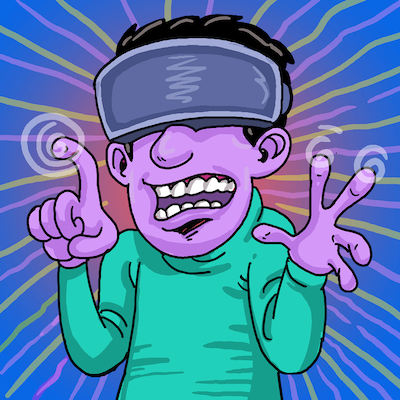

NFT with tokenId:  2


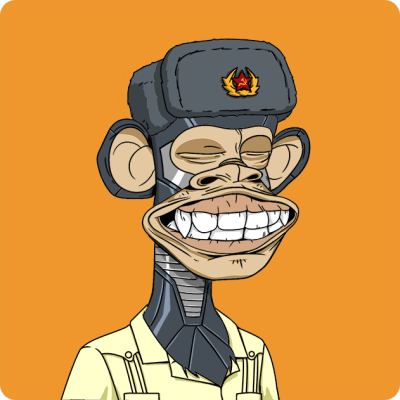

NFT with tokenId:  3


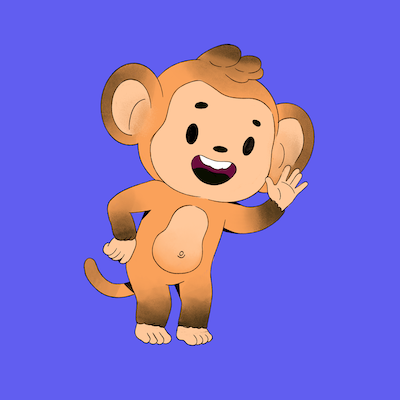

NFT with tokenId:  4


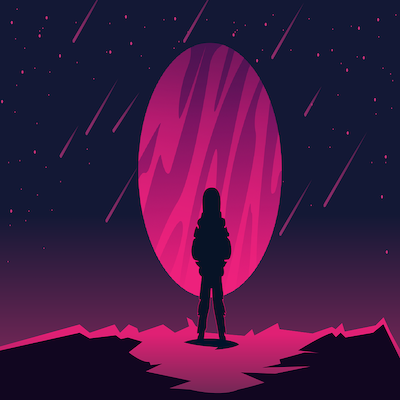

In [6]:
# First, display all NFTs that are currently listed in the marketplace.
list_market_nfts = nft_contract.functions.fetchMarketItems().call() 
display_NFTs(list_market_nfts)

In [7]:
# important: in order to unlock the account, start the local node with the following parameters:
# geth --datadir ~/.uzheth --http --http.port 8545 --http.corsdomain "*" --http.vhosts "*" 
# --http.api miner,eth,admin,net,web3,personal --networkid 702 --syncmode "full" --http.addr 0.0.0.0 
# --allow-insecure-unlock

# Prompt the user get provide the password
print("Please provide the password for the selected user:", web3.eth.default_account)
password = getpass.getpass() # test33test
# password = "test33test"

# Unlock selected account (which has ben set to the default_account in the previous section)
web3.geth.personal.unlock_account(web3.eth.default_account, password)

# Prompt user to specify the metadata for his/her NFT
print("Please specify the location of the metadata file (IPFS format):")
ipfs_path = input() # ipfs://QmP2FeSDSYnrwEFXTsyDkVN1J19dceSLgN4MgVMSmtoYQ8
# ipfs_path = "ipfs://QmP2FeSDSYnrwEFXTsyDkVN1J19dceSLgN4MgVMSmtoYQ8"
    
# Default price (in WEI) to purchase this nft will be set:
default_price = 10

# Get current listPrice from the smart contract
default_value = nft_contract.functions.getListingPrice().call()

# Create token via the smart contract
tx_hash = nft_contract.functions.createToken(ipfs_path, default_price).transact(
    {'to': nft_marketplace_contract_addr, 
     'gas': 420000, 
     'gasPrice': 1000000000,
     'value': default_value})

# print transaction details
print("your transaction details:")
tx_hash

Please provide the password for the selected user: 0xeAfeb3f4aa13CA4027cC9ae1aFe5C6102aa4C786
········
Please specify the location of the metadata file (IPFS format):
ipfs://QmP2FeSDSYnrwEFXTsyDkVN1J19dceSLgN4MgVMSmtoYQ8
your transaction details:


HexBytes('0x939295894e0198870b165c021d47a9cb7b85bed72e7ee5e3028698598e256c16')

In [8]:
# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = web3.eth.wait_for_transaction_receipt(tx_hash)
tx_receipt

AttributeDict({'blockHash': HexBytes('0xd9d2a251c5d089e7d6e17af42d202b4da59425e9895c685fbc292564b414c354'),
 'blockNumber': 3776681,
 'contractAddress': None,
 'cumulativeGasUsed': 223790,
 'effectiveGasPrice': 1000000000,
 'from': '0xeAfeb3f4aa13CA4027cC9ae1aFe5C6102aa4C786',
 'gasUsed': 223790,
 'logs': [AttributeDict({'address': '0x9b0E420E397305522eaA9D96d8fdDDB0DB9e8Db5',
   'topics': [HexBytes('0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'),
    HexBytes('0x0000000000000000000000000000000000000000000000000000000000000000'),
    HexBytes('0x000000000000000000000000eafeb3f4aa13ca4027cc9ae1afe5c6102aa4c786'),
    HexBytes('0x0000000000000000000000000000000000000000000000000000000000000006')],
   'data': '0x',
   'blockNumber': 3776681,
   'transactionHash': HexBytes('0x939295894e0198870b165c021d47a9cb7b85bed72e7ee5e3028698598e256c16'),
   'transactionIndex': 0,
   'blockHash': HexBytes('0xd9d2a251c5d089e7d6e17af42d202b4da59425e9895c685fbc292564b414c354'),
   'l

NFT with tokenId:  1


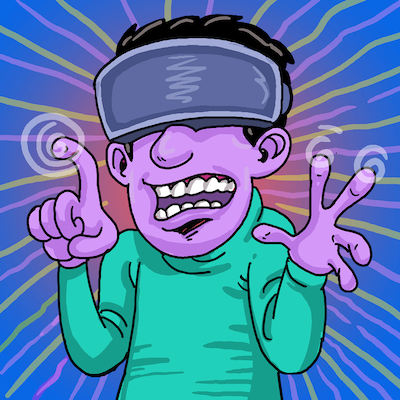

NFT with tokenId:  2


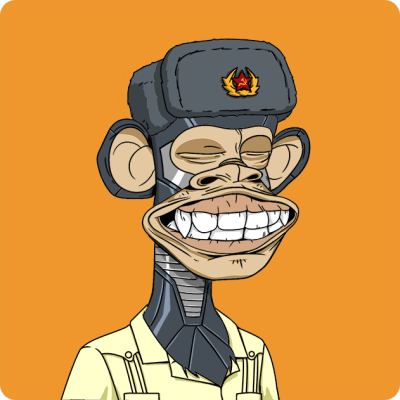

NFT with tokenId:  3


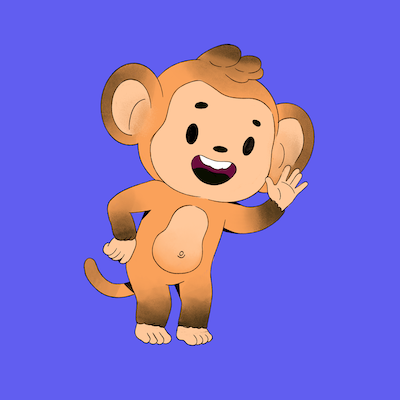

NFT with tokenId:  4


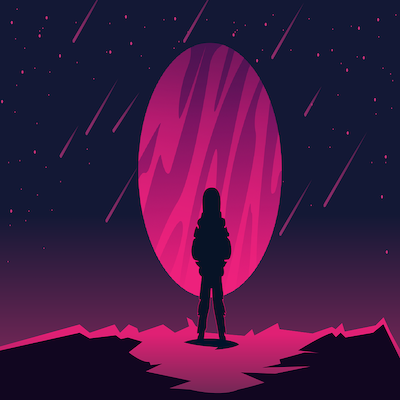

NFT with tokenId:  6


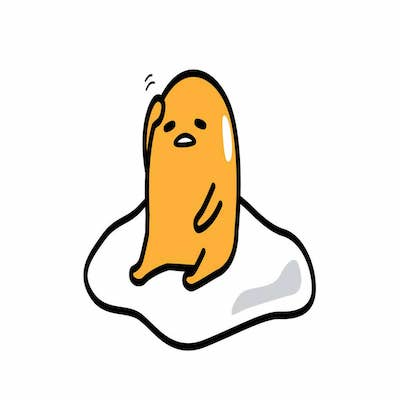

In [9]:
# Display all marketplace NFTs, it should be now one more.
list_market_nfts = nft_contract.functions.fetchMarketItems().call() 
display_NFTs(list_nfts=list_market_nfts)

#### 4.) Buy a NFT on the marketplace

NFT with tokenId:  5


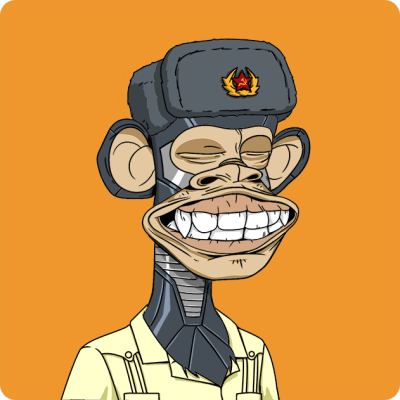

In [10]:
# First, list my current NFTs
list_my_nfts = nft_contract.functions.fetchMyNFTs().call() 
display_NFTs(list_my_nfts)

In [11]:
# Ask user which NFT he/ she would like to buy from the marketplace (displayed two cells above)

print("Plese specify which NFT you would like to buy (tokenId required):")
tokenId_buy = int(input())

# Retrieve the price of the selected NFT
price_nft = nft_contract.functions.getNftPrice(tokenId_buy).call() 
print(f"The price for the selected NFT is (in WEI): {price_nft}")

# Prompt user for the password
print("please provide the password for the selected user: ", web3.eth.default_account)
password = getpass.getpass() # test33test
# password = "test33test"

# unlock account and perform transacation
web3.geth.personal.unlock_account(web3.eth.default_account, password)
tx_hash = nft_contract.functions.createMarketSale(tokenId_buy).transact({'value': price_nft})
tx_hash


Plese specify which NFT you would like to buy (tokenId required):
6
The price for the selected NFT is (in WEI): 10
please provide the password for the selected user:  0xeAfeb3f4aa13CA4027cC9ae1aFe5C6102aa4C786
········


HexBytes('0x98866782a3f2b78de5873f001de611fbccd9585c237a061c57761c14486d0f11')

In [12]:
# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = web3.eth.wait_for_transaction_receipt(tx_hash)
tx_receipt

AttributeDict({'blockHash': HexBytes('0x9ff64fb1a16946f4640bdf914f2667021b196bdaef33132a20bf108df857e1ee'),
 'blockNumber': 3776685,
 'contractAddress': None,
 'cumulativeGasUsed': 89857,
 'effectiveGasPrice': 1000000000,
 'from': '0xeAfeb3f4aa13CA4027cC9ae1aFe5C6102aa4C786',
 'gasUsed': 89857,
 'logs': [AttributeDict({'address': '0x9b0E420E397305522eaA9D96d8fdDDB0DB9e8Db5',
   'topics': [HexBytes('0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925'),
    HexBytes('0x0000000000000000000000009b0e420e397305522eaa9d96d8fdddb0db9e8db5'),
    HexBytes('0x0000000000000000000000000000000000000000000000000000000000000000'),
    HexBytes('0x0000000000000000000000000000000000000000000000000000000000000006')],
   'data': '0x',
   'blockNumber': 3776685,
   'transactionHash': HexBytes('0x98866782a3f2b78de5873f001de611fbccd9585c237a061c57761c14486d0f11'),
   'transactionIndex': 0,
   'blockHash': HexBytes('0x9ff64fb1a16946f4640bdf914f2667021b196bdaef33132a20bf108df857e1ee'),
   'log

NFT with tokenId:  5


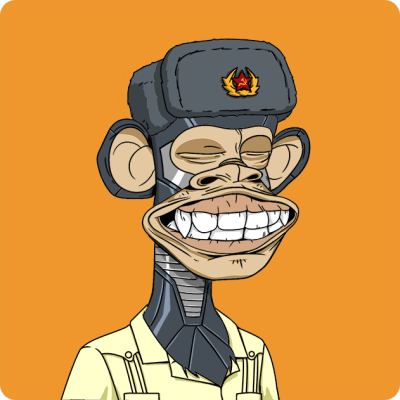

NFT with tokenId:  6


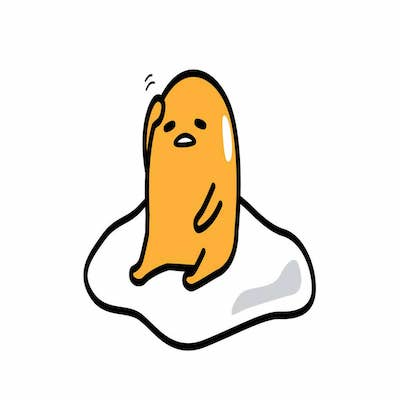

In [13]:
# Let's check if we are the new owner of the selected NFT
list_my_nfts = nft_contract.functions.fetchMyNFTs().call() 
display_NFTs(list_my_nfts)

#### 5.) Sell a NFT on the marketplace (and buy it with another account)

In [14]:
# First, we the user has to select a NFT 
print("Plese specify which NFT you would like to sell (tokenId required):")
tokenId_sell = int(input())

print("Please specify the price for this NFT (In WEI):" )
price_sell = int(input())

# Prompt user for the password
print("please provide the password for the selected user: ", web3.eth.default_account)
password = getpass.getpass() # test33test
# password = "test33test"

# Get current listPrice from the smart contract
listing_price = nft_contract.functions.getListingPrice().call()

# unlock account and perform transacation
web3.geth.personal.unlock_account(web3.eth.default_account, password)
tx_hash = nft_contract.functions.resellToken(tokenId_sell, price_sell).transact({'value': listing_price})
tx_hash


Plese specify which NFT you would like to sell (tokenId required):
6
Please specify the price for this NFT (In WEI):
1000
please provide the password for the selected user:  0xeAfeb3f4aa13CA4027cC9ae1aFe5C6102aa4C786
········


HexBytes('0x12d6c50c1930eef8fa5ba8be65863117448af05d17fa2df4ebeea8e7ecf06f31')

In [15]:
# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = web3.eth.wait_for_transaction_receipt(tx_hash)
tx_receipt

AttributeDict({'blockHash': HexBytes('0x8b0fe0639df49e1ee825f92da20aa09315a3309c3529b237579b191931889685'),
 'blockNumber': 3776692,
 'contractAddress': None,
 'cumulativeGasUsed': 78633,
 'effectiveGasPrice': 1000000000,
 'from': '0xeAfeb3f4aa13CA4027cC9ae1aFe5C6102aa4C786',
 'gasUsed': 78633,
 'logs': [AttributeDict({'address': '0x9b0E420E397305522eaA9D96d8fdDDB0DB9e8Db5',
   'topics': [HexBytes('0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925'),
    HexBytes('0x000000000000000000000000eafeb3f4aa13ca4027cc9ae1afe5c6102aa4c786'),
    HexBytes('0x0000000000000000000000000000000000000000000000000000000000000000'),
    HexBytes('0x0000000000000000000000000000000000000000000000000000000000000006')],
   'data': '0x',
   'blockNumber': 3776692,
   'transactionHash': HexBytes('0x12d6c50c1930eef8fa5ba8be65863117448af05d17fa2df4ebeea8e7ecf06f31'),
   'transactionIndex': 0,
   'blockHash': HexBytes('0x8b0fe0639df49e1ee825f92da20aa09315a3309c3529b237579b191931889685'),
   'log

In [16]:
# Switch the account 
def handle_change():
    print(users_dropdown.value)

list_users = web3.eth.accounts
users_dropdown = Dropdown(description="Select_User", options=list_users)
users_dropdown.on_trait_change(handle_change, name="value")
display(users_dropdown)


<ipython-input-16-7d835efd8026>:7: DeprecationWarning: on_trait_change is deprecated in traitlets 4.1: use observe instead
  users_dropdown.on_trait_change(handle_change, name="value")


Dropdown(description='Select_User', options=('0x12731036C9605f118BAd4D985C72cbD49Ed2a691', '0xeAfeb3f4aa13CA40…

0x0871447e71EB6aACC87c7700453aa679A04F9159


In [17]:
# Get Dropdown selection
selected_user = users_dropdown.value
selected_user = "0x0871447e71EB6aACC87c7700453aa679A04F9159"
print("You have selected the following user (public key): ", selected_user)

# Change default account to reflect selection
web3.eth.default_account = selected_user

# Show balance of selected user
balance_wei = web3.eth.getBalance(selected_user)
print(f'\nBalance in (UZH)Ether: {web3.fromWei(balance_wei, "ether")}')

You have selected the following user (public key):  0x0871447e71EB6aACC87c7700453aa679A04F9159

Balance in (UZH)Ether: 4.99211153899999987


In [18]:
# Display all NFT of this newly selceted account
list_my_nfts = nft_contract.functions.fetchMyNFTs().call() 
display_NFTs(list_my_nfts)

In [19]:
# Ask user which NFT he/ she would like to buy from the marketplace
print("Plese specify which NFT you would like to buy (tokenId required):")
tokenId_buy = int(input())

# Retrieve the price of the selected NFT
price_nft = nft_contract.functions.getNftPrice(tokenId_buy).call() 
print(f"The price for the selected NFT is (in WEI): {price_nft}")

# Prompt user for the password
print("\nplease provide the password for the selected user: ", web3.eth.default_account)
password = getpass.getpass() # test33test
# password = "test33test"

# unlock account and perform transacation
web3.geth.personal.unlock_account(web3.eth.default_account, password)
tx_hash = nft_contract.functions.createMarketSale(tokenId_buy).transact({'value': price_nft})
tx_hash

Plese specify which NFT you would like to buy (tokenId required):
6
The price for the selected NFT is (in WEI): 1000

please provide the password for the selected user:  0x0871447e71EB6aACC87c7700453aa679A04F9159
········


HexBytes('0x4bca5e93e793d2c53d54bec3d95812edf578065a7f41cc6c1d778587187013f1')

In [20]:
# Wait for the transaction to be mined, and get the transaction receipt
tx_receipt = web3.eth.wait_for_transaction_receipt(tx_hash)
tx_receipt

AttributeDict({'blockHash': HexBytes('0x503be1b62eeeea634cbf2285ef500ec60f400f0f939ab8c953cf4b8e560e1a6c'),
 'blockNumber': 3776695,
 'contractAddress': None,
 'cumulativeGasUsed': 104857,
 'effectiveGasPrice': 1000000000,
 'from': '0x0871447e71EB6aACC87c7700453aa679A04F9159',
 'gasUsed': 104857,
 'logs': [AttributeDict({'address': '0x9b0E420E397305522eaA9D96d8fdDDB0DB9e8Db5',
   'topics': [HexBytes('0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925'),
    HexBytes('0x0000000000000000000000009b0e420e397305522eaa9d96d8fdddb0db9e8db5'),
    HexBytes('0x0000000000000000000000000000000000000000000000000000000000000000'),
    HexBytes('0x0000000000000000000000000000000000000000000000000000000000000006')],
   'data': '0x',
   'blockNumber': 3776695,
   'transactionHash': HexBytes('0x4bca5e93e793d2c53d54bec3d95812edf578065a7f41cc6c1d778587187013f1'),
   'transactionIndex': 0,
   'blockHash': HexBytes('0x503be1b62eeeea634cbf2285ef500ec60f400f0f939ab8c953cf4b8e560e1a6c'),
   'l

NFT with tokenId:  6


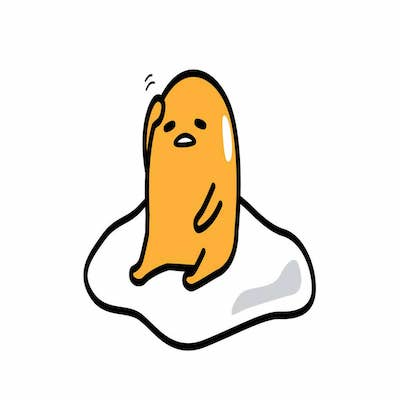

In [21]:
# We can see that we have bought a NTF
list_my_nfts = nft_contract.functions.fetchMyNFTs().call() 
display_NFTs(list_my_nfts)

NFT with tokenId:  1


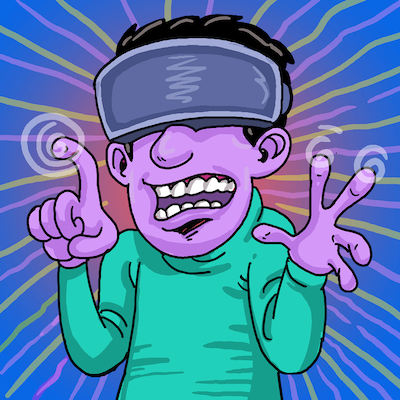

NFT with tokenId:  2


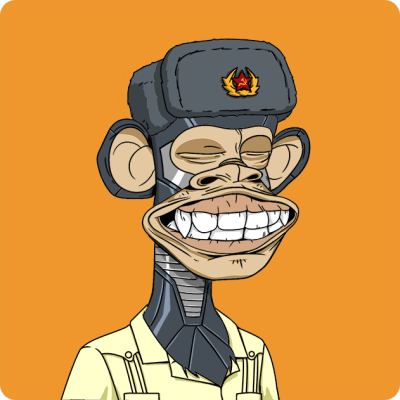

NFT with tokenId:  3


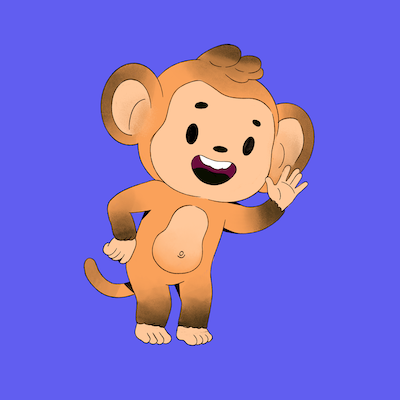

NFT with tokenId:  4


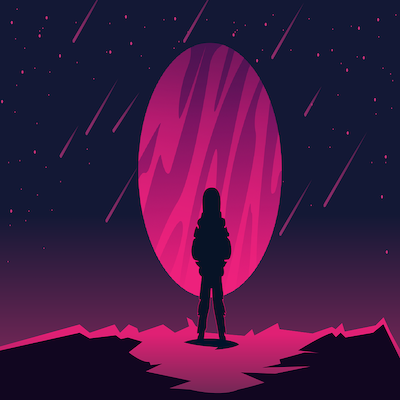

In [22]:
# Display the current listing of the markeplace
list_market_nfts = nft_contract.functions.fetchMarketItems().call() 
display_NFTs(list_nfts=list_market_nfts)

In [ ]:
# end of NFT Marketplace
"""
Some last words: In the original version, we retrieved the images via an interface https://app.pinata.cloud/pinmanager.
However, as shown on the image below, they have blocked our queries after a couple of tries. We therefore we forced to
work with local image files. The associated metadata file is linked with the local images. With a payed option, we 
would be able to query the images from pinata with the ipfs links. Here the unused code to do that:

def display_NFTs(list_nfts=[]):
    # Retrieve ipfs of each NFT
    # list_token_URIs = []
    for nft in list_nfts:
        tokenId_nft = nft[0] # 1,2,3 etc.
        
        # Sleep for one second otherwise we face problems with the image retrival
        time.sleep(1)

        # Sourcing data from external uri; This is prone to errors and therefore we will
        # put the code in this try/except block
        print(f"NFT with tokenId: ", tokenId_nft)
        try:
            # Get tokenUri and use it to retrieve the JSON metadata file
            token_uri = nft_contract.functions.tokenURI(tokenId_nft).call() # 'ipfs://QmZ9Q3kApo1muuM3gd3cgEa7vZeaHnHjZr9bhKZ8QhNmKz'
            token_uri = token_uri.rsplit('//', 1)[1] # QmZ9Q3kApo1muuM3gd3cgEa7vZeaHnHjZr9bhKZ8QhNmKz
            # list_token_URIs.append(token_uri)
            url_metadata = "https://gateway.pinata.cloud/ipfs/" + token_uri # https://gateway.pinata.cloud/ipfs/QmZ9Q3kApo1muuM3gd3cgEa7vZeaHnHjZr9bhKZ8QhNmKz
            obj_metadata_json = requests.get(url_metadata)
            image_uri = obj_metadata_json.json()["image"]

            # Adjust the link and download the image
            image_uri = image_uri.rsplit('//', 1)[1] # QmcX4K8PttnReg67EtGF2hhcCDy49VayWkVS1WCM8eayDD
            image_uri = "https://gateway.pinata.cloud/ipfs/" + image_uri

            # Display image
            obj_nft_image = Image.open(requests.get(image_uri, stream=True).raw)
            display(obj_nft_image.resize((80, 80)))
            
        except:
            print(f"Got an error while retrieving the NFT with tokenId={tokenId_nft}")
    return

"""
str_image = "./img/pinata_image_query_error.png"
display(Image(filename=str_image, width = 500))